# Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2. Классификация изображений. Сверточные нейронные сети.

### Общая информация

Дата выдачи: 07.11.2021

Мягкий дедлайн: 23:59MSK 28.11.2021

Жесткий дедлайн: 23:59MSK 02.12.2021


### О задании

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=0).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

## Задание 1. (Максимум 10 баллов + 5 бонусных баллов)

__Необходимо выполнить любое из двух заданий (на выбор)__

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить
все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров). Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 45 минут обучения.
 
Good luck & have fun! :)

In [1]:
import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import pandas as pd

from IPython.display import display, clear_output
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 14, 8

In [2]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(10)

### Подготовка данных

In [3]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2021-12-05 14:43:42--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2021-12-05 14:43:42--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc4e63f0ffdd3a66095effc2ca8.dl.dropboxusercontent.com/cd/0/get/BbQBbKcHiL8WGneiu9UvrNyxf7CCePhkIU90FPrKgOHUllvliYNlcdCKqkBDVz9p-suG5NZGbANyYFNbyr33DgbZ_NrwtiiRHDg-IM3s8WFKK0-rkbWEL75QY9iZeg71lTQhsaN9A-qGhVwbSzw98FRq/file?dl=1# [following]
--2021-12-05 14:43:42--  https://ucc4e63f0ffdd3a66095effc2ca8.dl.dropboxusercontent.com/cd/0/get/BbQBbKcHiL8WGneiu9UvrNyxf7CCePhkIU90FPrKgOHUllvliYNlcdCKqkBDVz9p-suG5NZGbANyYFNbyr33DgbZ_Nr

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = ImageFolder("dataset/dataset/train", transform=train_transform)
val_dataset = ImageFolder("dataset/dataset/val", transform=val_transform)

BATCH_SZ = 200
# drop last - ?
train_loader = DataLoader(train_dataset, batch_size=BATCH_SZ, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SZ, shuffle=False, num_workers=6, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [6]:
def train_one_epoch(model, train_loader, criterion, optimizer, device="cuda:0"):
    model.train()
    loss_values, metric_values = [], []
    for x_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()
        y_batch = y_batch.to(device)
        logits = model(x_batch.to(device))
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
        metric_values.append(
            (logits.argmax(dim=-1) == y_batch).sum().item()
        )
            
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    axes[0].plot(loss_values, 'darkorchid', linewidth=2)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('One Epoch Loss - Iteration')
    
    axes[1].plot(metric_values, 'lime', linewidth=2)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('One Epoch Accuracy - Iteration')
    plt.show()
    
    print('Min loss: %.3f' %(np.min(loss_values)))
    print('Max accuracy: %.3f' %(np.max(metric_values)))

def predict(model, val_loder, criterion, device="cuda:0"):
    model.eval()
    losses = []
    true_classes = np.array([])
    predicted_classes = np.array([])
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_loader):
            y_batch = y_batch.to(device)
            y_pred = model(x_batch.to(device)) 
            loss = criterion(y_pred, y_batch)
            losses.append(loss.item() * len(y_batch))
            predicted_classes = np.append(predicted_classes, y_pred.argmax(1).to('cpu'))
            true_classes = np.append(true_classes, y_batch.to('cpu'))
    return losses, predicted_classes, true_classes

In [7]:
def plot_graphs(metrics_dict):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    axes[0].plot(metrics_dict['Epoch'], metrics_dict['Train Loss'], 'darkorchid', label='Train', linewidth=2)
    axes[0].plot(metrics_dict['Epoch'], metrics_dict['Valid Loss'], 'crimson', label='Valid', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss - Epoch')
    axes[0].legend(shadow=False, fontsize=14)
    
    axes[1].plot(metrics_dict['Epoch'], metrics_dict['Train Metric'], 'darkorchid', label='Train', linewidth=2)
    axes[1].plot(metrics_dict['Epoch'], metrics_dict['Valid Metric'], 'crimson', label='Valid', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy - Epoch')
    axes[1].legend(shadow=False, fontsize=14)
    plt.show()

In [26]:
def train(model, optimizer, criterion, train_loader, valid_loader, scheduler=None, device='cpu', epochs=10):
    metrics_dict = { 'Epoch': [], 'Train Loss': [], 'Valid Loss': [], 'Train Metric': [], 'Valid Metric': [] }
 
    for epoch in range(epochs):
        metrics_dict['Epoch'].append(epoch + 1)
        
        model.train()
        train_loss, train_metric = 0, 0
        for x_batch, y_batch in tqdm(train_loader):
            optimizer.zero_grad()
            y_batch = y_batch.to(device)
            logits = model(x_batch.to(device))
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(y_batch)
            train_metric += (logits.argmax(dim=-1) == y_batch).sum().item()
                
        train_loss /= len(train_loader.dataset)
        train_metric /= len(train_loader.dataset)
        metrics_dict['Train Loss'].append(train_loss)
        metrics_dict['Train Metric'].append(train_metric)

        if scheduler is not None:
            if metrics_dict['Epoch'][-1] >= 3 and \
              (abs(metrics_dict['Train Metric'][-1] - metrics_dict['Train Metric'][-2]) < 0.05 or \
              metrics_dict['Train Metric'][-1] < metrics_dict['Train Metric'][-2]):
                scheduler.step()
        
        model.eval()
        valid_loss, valid_metric = 0, 0
        for x_batch_v, y_batch_v in tqdm(valid_loader):
            y_batch_v = y_batch_v.to(device)
            with torch.no_grad():
                logits_v = model(x_batch_v.to(device))
                loss = criterion(logits_v, y_batch_v)
            valid_loss += loss.item() * len(y_batch_v)
            valid_metric += (logits_v.argmax(dim=-1) == y_batch_v).sum().item()
                
        valid_loss /= len(valid_loader.dataset)
        valid_metric /= len(valid_loader.dataset)
        metrics_dict['Valid Loss'].append(valid_loss)
        metrics_dict['Valid Metric'].append(valid_metric)
    
        clear_output(wait=True)
        display(pd.DataFrame(metrics_dict))
        
    plot_graphs(metrics_dict)

### Обучение модели, запуски экспериментов

In [27]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Seq = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, stride=2, padding=3, dilation=1, bias=False),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(100, 250, kernel_size=3, padding=1),
            nn.BatchNorm2d(250),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(250, 400, kernel_size=3, dilation=1, padding=1, bias=False),
            nn.BatchNorm2d(400),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(400, 750, kernel_size=3, padding=1),
            nn.BatchNorm2d(750),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
        )
        
        self.Head = nn.Sequential(
            nn.Linear(750, 200)
        )
        
    def forward(self, images):
        features = self.Seq(images)
        features = features.mean(dim=(2, 3))
        logits = self.Head(features)
        return logits

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = ConvNet()
model.to(device)
model_device = next(model.parameters()).device
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.8, 0.8), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss()
model_device

device(type='cuda', index=0)

,Epoch,Train Loss,Valid Loss,Train Metric,Valid Metric
0,1,4.096883,3.937037,0.13097,0.1579
1,2,3.387784,3.483233,0.23739,0.2238
2,3,3.087242,3.227000,0.29135,0.2680
3,4,2.868493,3.257486,0.33043,0.2714
4,5,2.668298,2.918459,0.36985,0.3229
5,6,2.497906,2.903579,0.40487,0.3275
6,7,2.356891,2.734308,0.43310,0.3645
7,8,2.232439,2.768204,0.46017,0.3646
8,9,2.115946,2.644292,0.48381,0.3840
9,10,2.008559,2.609157,0.50728,0.3919


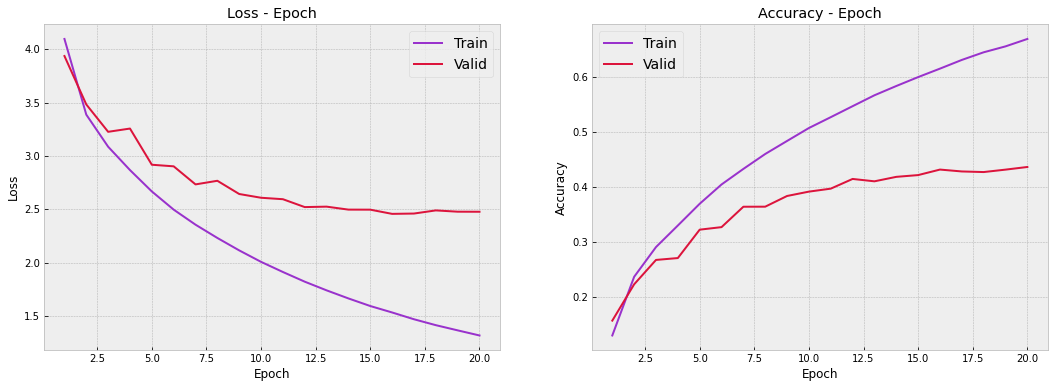

In [28]:
torch.cuda.empty_cache()
train(model, optimizer, criterion, train_loader, val_loader, device=model_device, scheduler=scheduler, epochs=20)

,Epoch,Train Loss,Valid Loss,Train Metric,Valid Metric
0,1,1.278163,2.470760,0.67863,0.4359
1,2,1.250101,2.502018,0.68553,0.4329
2,3,1.215129,2.490157,0.69566,0.4340
3,4,1.182487,2.513116,0.70367,0.4344
4,5,1.150976,2.499607,0.71271,0.4379


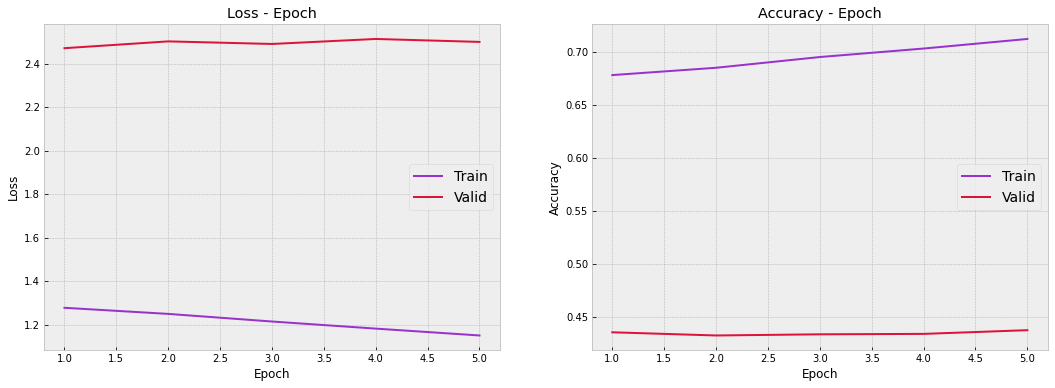

In [31]:
train(model, optimizer, criterion, train_loader, val_loader, device=model_device, scheduler=scheduler, epochs=5)

Простой тест на проверку правильности написанного кода

In [32]:
all_losses, predicted_labels, true_labels = predict(model, val_loader, criterion, model_device)
assert len(predicted_labels) == len(val_dataset)
accuracy = (predicted_labels == true_labels).sum().item() / len(true_labels)
print("tests passed")

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tests passed


Запустить обучение можно в ячейке ниже.

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [33]:
print(f'Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов,'\
      f' если вы делали часть 1, и {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов,'\
      f' если вы делали часть 2.')

Оценка за это задание составит 9.95 баллов, если вы делали часть 1, и 0.00 баллов, если вы делали часть 2.


## Задание 2 (0 баллов, но при невыполнении максимум за все задание — 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

#M1
Начал я с модели, представленной на семинаре нашей группы:

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Seq = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 200, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(200, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
        )
        
        self.Head = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 200)
        )
        
    def forward(self, images):
        features = self.Seq(images)
        features = features.mean(dim=(2, 3))
        logits = self.Head(features)
        return logits

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.8, 0.8), weight_decay=1e-4)

Размет пакета составлял 250, параметры оптимизатора были подобраны именно такие. Стоит отметить, что значение `lr = 1e-3` работало хорошо, отклонения в любую сторону на одну степень показывали плохие результаты.

Данная модель обучалась достаточно быстро, и достигла качества 0.24 на 10 эпохе.

Позднее я добавил `RandomHorizontalFlip()` как аугментацию, что помогло поднять качество до 0.2647 на 10 эпохе, а на 15 - 0.2813.

Далее я решил посмотреть, как буду влиять на модель функции активации. Остановился я на `ReLU()` как на проверенном варианте. Выяснилось, что множественные активации (после каждой свертки) плохо влияли на модель, а лучше всего себя показала одна активация: `ReLU()` после первой свертки - 0.2829; после второй свертки - 0.2922 (на 15 эпохе).

#M2
В следующей модели я немного увеличил ширину слоев, а также убрал один полносвязный слой и активацию, повысил первый `MaxPool2d` (с уменьшения картинки в два раза до уменьшения в 4 раза). Пробовал и `AvgPool2d`, но ощутимых результатов это не принесло. Настройки оптимизатора и размер пакета не менялись.

Запустив на 60 эпох, заметил, что качество в 0.33 было получено на 15 эпохе, максимальное - 0.35. Выше качество добиться не получилось - на тесте не было роста, лишь мелкие колебания. Переобучения тоже не было. Тем не менее, с проблемой преодолжения порога 0.35 я просидел несколько дней.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Seq = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 200, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(200, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            
        )
        
        self.Head = nn.Sequential(
            nn.Linear(128, 200)
        )

Позднее к этой модели была добавлена нормализация `T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))`. Получилось ускорить обучение, достигнув качества 0.33 на 11 эпохе, 0.34 на 15 эпохе, выше - уже никак.

#M3
В какой-то момент стало понятно, что следует использоваь более широкие слои.

К этому моменту я уже использовал `AdamW` с теми же параметрами, размер пакета снизился до 200. Иногда использовал `ExponentialLR`-планировщик. Было проведено много экспериментов с моделями такого рода, где я пытался менять размер ядра свертки, шаг свертки, паддинг, число полносвязных и сверточных слоев, пробовал пуллинги с различными параметрами ядра. В результате я несколько ускорил обучение (0.35 на 15 эпохе), но дальше по-прежнему никак ни шло. Пример такой модели:

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Seq = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 180, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(180, 80, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            
        )
        
        self.Head = nn.Sequential(
            nn.Linear(128, 200)
        )
        
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.8, 0.8), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

#M4
Наконец, я решил попробовать другую схему составления сверточных слоев. Если сначала я делал число каналов от меньшего к большему, а затем снова к меньшему, то теперь я решил делать просто от меньшего к большему. Кроме того, добавил активаций после каждой свертки несмотря на то, что в прошлые разы это ухудшало модель. Попытка не пытка - решил дать `ReLU()` второй шанс.

Также я переписал условия для шага планировщика - шаг делался раз в эпоху, когда предпоследнее и последнее значения `accuracy` было меньше 0.03 по абсолютному значению. Было замечено, что скорость сходимости падает именно с 15 эпохи, но это условие я не стал вносить, дабы избежать явных костылей.

Кроме того, были добавлены батчнормы и дополнительная аугментация `RandomVerticalFlip()`. Больше добавлять не стал, поскольку есть еще `weight_decay` - регуляризация уже была более чем достаточной.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Seq = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
        )
        
        self.Head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 200)
        )
    
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Данная модель наконец пробила потолок в 0.35 и достигла качества 0.38 на 20 эпохе.

#M5
Данная модель - аналог предудыщей (по сути просто увеличена ширина слоев), но при этом - 0.4269 на 20 эпохе.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Seq = nn.Sequential(
            nn.Conv2d(3, 80, kernel_size=3, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(80),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(80, 150, kernel_size=3, padding=3),
            nn.BatchNorm2d(150),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(150, 300, kernel_size=3, padding=1),
            nn.BatchNorm2d(300),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(300, 600, kernel_size=3, padding=1),
            nn.BatchNorm2d(600),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
        )
        
        self.Head = nn.Sequential(
            nn.Linear(600, 200)
        )
        
    def forward(self, images):
        features = self.Seq(images)
        features = features.mean(dim=(2, 3))
        logits = self.Head(features)
        return logits

#M6
Несколько экспериментов с увеличением ширины, добавления параметра `dilation` в сверточные слои. Результат - 0.4342 на 20 эпохе.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Seq = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, stride=2, padding=3, dilation=1, bias=False),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(100, 200, kernel_size=3, padding=1),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(200, 400, kernel_size=3, dilation=1, padding=1, bias=False),
            nn.BatchNorm2d(400),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(400, 600, kernel_size=3, padding=1),
            nn.BatchNorm2d(600),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
        )
        
        self.Head = nn.Sequential(
            nn.Linear(600, 200)
        )
        
    def forward(self, images):
        features = self.Seq(images)
        features = features.mean(dim=(2, 3))
        logits = self.Head(features)
        return logits

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.8, 0.8), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Еще я пробовал инициализировать веса по Ксавьеру (нормальное и равномерное распределение), но это не помогло никаким образом.

К сожалению, у меня не получилось выбить 0.44. Вроде бы близко, но никак. Грустно.